<a href="https://colab.research.google.com/github/WiggleCode/AAI-530-IoT-Application-Design-Final-Project/blob/Jeffs-Workspace/Models%20in%20work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential

In [2]:
df_raw = pd.read_csv('IoTProcessed_Data.csv')

df_raw.head()

,date,tempreature,humidity,water_level,N,P,K,Fan_actuator_OFF,Fan_actuator_ON,Watering_plant_pump_OFF,Watering_plant_pump_ON,Water_pump_actuator_OFF,Water_pump_actuator_ON
0,2024-02-08 06:10:00,41,63,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
1,2024-02-08 06:15:00,41,59,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
2,2024-02-08 06:20:00,41,62,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-02-08 06:05:00,40,60,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
4,2024-02-08 06:00:00,39,61,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0


In [3]:
df = df_raw.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37922 entries, 0 to 37921
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     37920 non-null  object 
 1   tempreature              37922 non-null  int64  
 2   humidity                 37922 non-null  int64  
 3   water_level              37922 non-null  int64  
 4   N                        37922 non-null  int64  
 5   P                        37922 non-null  int64  
 6   K                        37922 non-null  int64  
 7   Fan_actuator_OFF         37922 non-null  float64
 8   Fan_actuator_ON          37922 non-null  float64
 9   Watering_plant_pump_OFF  37922 non-null  float64
 10  Watering_plant_pump_ON   37922 non-null  float64
 11  Water_pump_actuator_OFF  37922 non-null  float64
 12  Water_pump_actuator_ON   37922 non-null  float64
dtypes: float64(6), int64(6), object(1)
memory usage: 3.8+ MB


In [4]:
# Creating a 'datetime' timeseries feature from object Dtype 'date'
df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Code format pulled from Dylan Scott-Dawkins
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

In [6]:
df_grouped_day = df.groupby(df['day'])

df_grouped_day.value_counts()

day   date                 tempreature  humidity  water_level  N    P    K    Fan_actuator_OFF  Fan_actuator_ON  Watering_plant_pump_OFF  Watering_plant_pump_ON  Water_pump_actuator_OFF  Water_pump_actuator_ON  datetime             hour  month
1.0   2023-12-01 00:04:00  23           59        100          185  190  160  0.0               1.0              1.0                      0.0                     1.0                      0.0                     2023-12-01 00:04:00  0.0   12.0     1
      2023-12-01 00:09:00  23           60        100          185  190  160  0.0               1.0              1.0                      0.0                     1.0                      0.0                     2023-12-01 00:09:00  0.0   12.0     1
      2023-12-01 00:13:00  23           59        100          185  190  160  0.0               1.0              1.0                      0.0                     1.0                      0.0                     2023-12-01 00:13:00  0.0   12.0     1
      2023-12-01 00:18:00  23           59        100          185  190  160  0.0               1.0              1.0                      0.0                     1.0                      0.0                     2023-12-01 00:18:00  0.0   12.0     1
      2023-12-01 00:23:00  23           61        100          185  190  160  0.0               1.0              1.0                      0.0                     1.0                      0.0                     2023-12-01 00:23:00  0.0   12.0     1
                                                                                                                                                                                                                                                      ..
31.0  2024-01-31 23:35:00  8            57        100          255  255  255  1.0               0.0              1.0                      0.0                     1.0                      0.0                     2024-01-31 23:35:00  23.0  1.0      1
      2024-01-31 23:40:00  9            58        100          255  255  255  1.0               0.0              1.0                      0.0                     1.0                      0.0                     2024-01-31 23:40:00  23.0  1.0      1
      2024-01-31 23:45:00  9            59        100          255  255  255  1.0               0.0              1.0                      0.0                     1.0                      0.0                     2024-01-31 23:45:00  23.0  1.0      1
      2024-01-31 23:50:00  10           57        100          255  255  255  1.0               0.0              1.0                      0.0                     1.0                      0.0                     2024-01-31 23:50:00  23.0  1.0      1
      2024-01-31 23:55:00  11           57        100          255  255  255  1.0               0.0              1.0                      0.0                     1.0                      0.0                     2024-01-31 23:55:00  23.0  1.0      1
Name: count, Length: 37920, dtype: int64

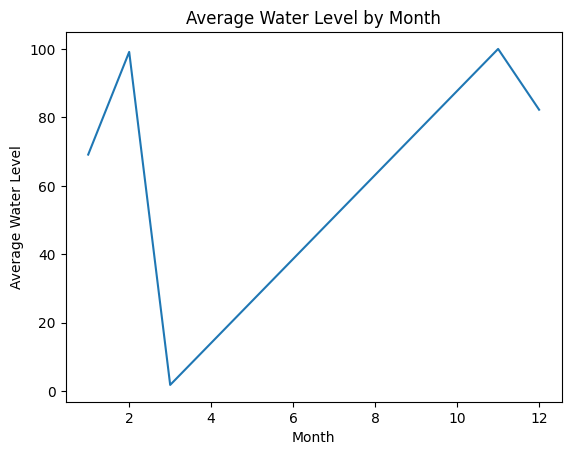

In [7]:

# Calculation of average water used by month
water_level_by_month = df.groupby('month')['water_level'].mean().plot()
water_level_by_month.set_title('Average Water Level by Month')
water_level_by_month.set_xlabel('Month')
water_level_by_month.set_ylabel('Average Water Level')
plt.show()

<Axes: xlabel='water_level', ylabel='Count'>

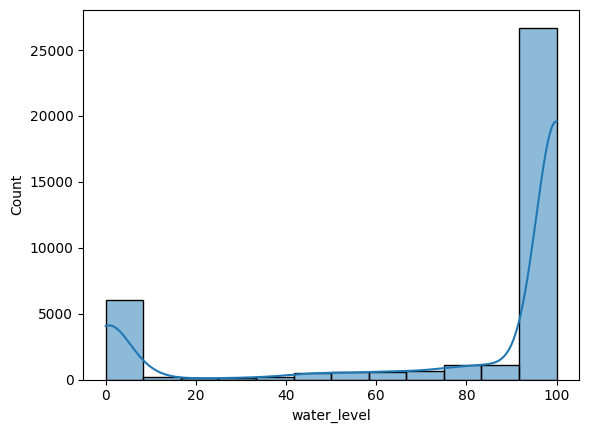

In [14]:
sns.histplot(data=df, x='water_level', bins=12, kde=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37922 entries, 0 to 37921
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     37920 non-null  datetime64[ns]
 1   tempreature              37922 non-null  int64         
 2   humidity                 37922 non-null  int64         
 3   water_level              37922 non-null  int64         
 4   N                        37922 non-null  int64         
 5   P                        37922 non-null  int64         
 6   K                        37922 non-null  int64         
 7   Fan_actuator_OFF         37922 non-null  float64       
 8   Fan_actuator_ON          37922 non-null  float64       
 9   Watering_plant_pump_OFF  37922 non-null  float64       
 10  Watering_plant_pump_ON   37922 non-null  float64       
 11  Water_pump_actuator_OFF  37922 non-null  float64       
 12  Water_pump_actuator_ON   37922 n

<Axes: xlabel='datetime', ylabel='Temperature (°C)'>

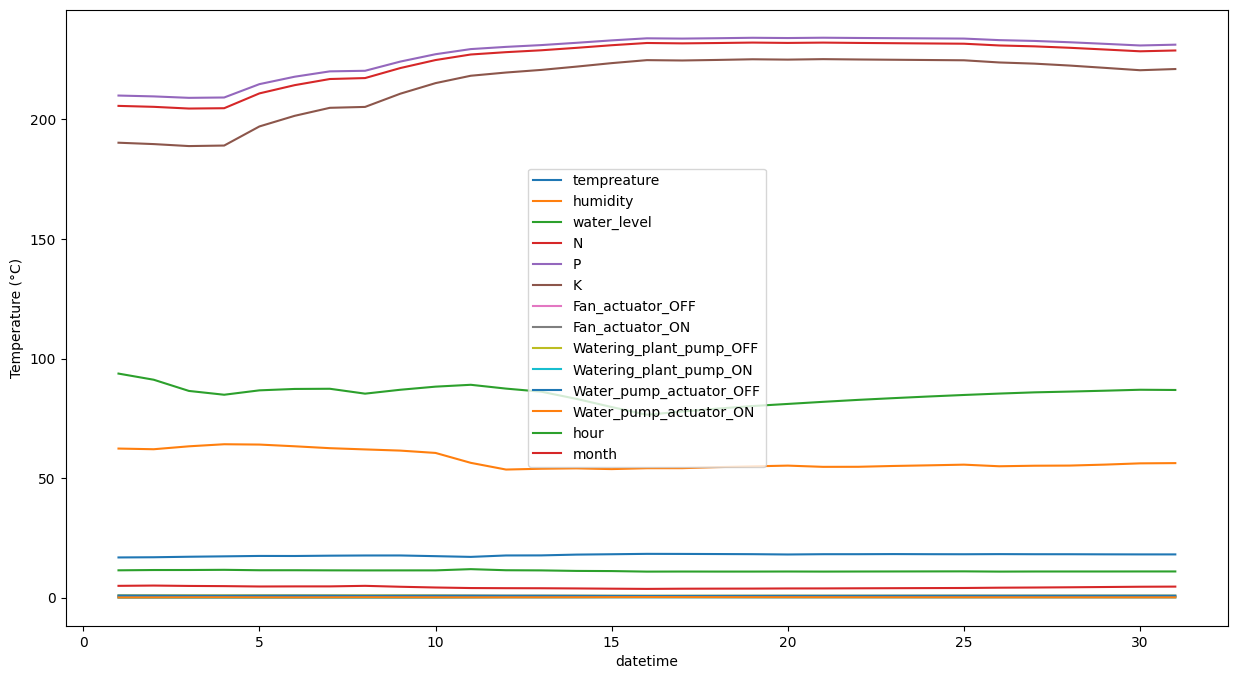

In [14]:
# Calculates the 30 day rolling mean over 12 months
# Shows warmer temp. during the middle of all months
df_grouped_day_numeric = df_grouped_day.mean(numeric_only=True)
df_grouped_day_numeric.rolling(30, min_periods=1).mean().plot(
    ylabel='Temperature (°C)',
    xlabel='datetime',
    figsize=(15, 8),
)

<Axes: title={'center': '12-Month Rolling Mean of Water Level'}, xlabel='Month', ylabel='Average Water Level'>

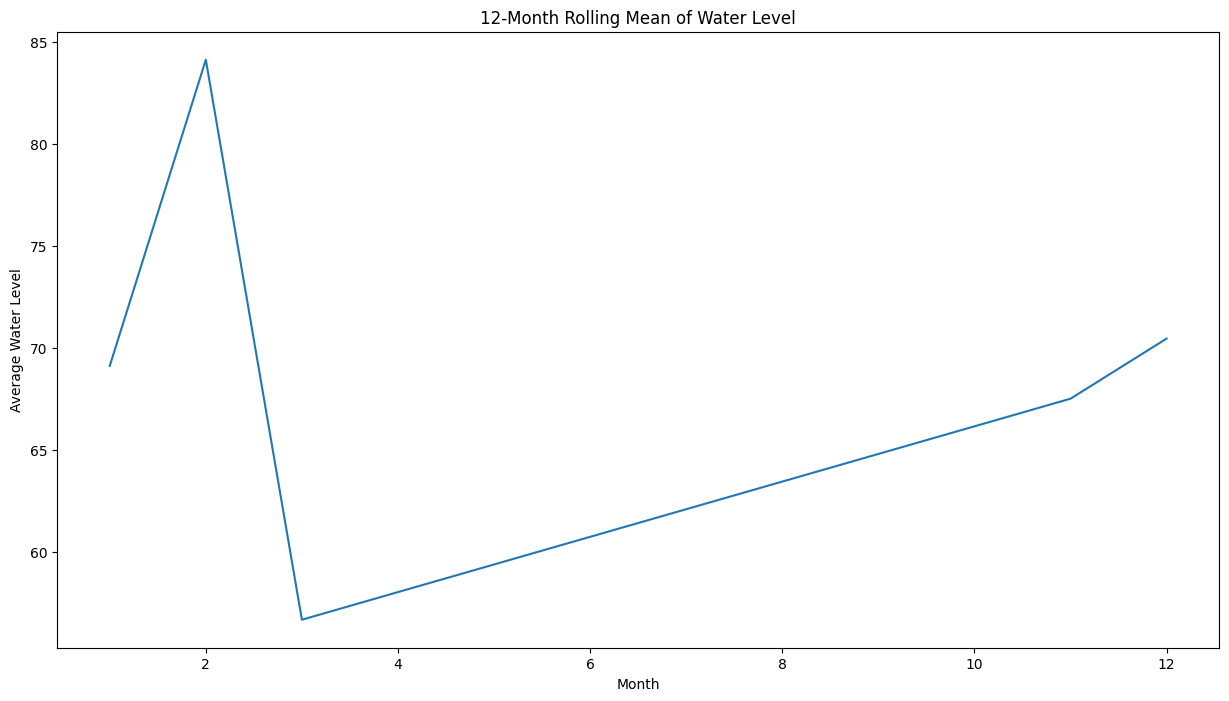

In [26]:
df_grouped_month = df.groupby('month')['water_level'].mean()

df_grouped_month.rolling(12, min_periods=1).mean().plot(
    ylabel='Average Water Level',
    xlabel='Month',
    figsize=(15, 8),
    title='12-Month Rolling Mean of Water Level'
)